# Cosmic Ray Flux Study

In the previous series of Notebooks, we've studied five individual data transformations, learning what each one does:

* **Wire Delay**: Corrects time data to account for the effects of wire delays
* **Combine**: Combines multiple input data sources into a single output file
* **SingleChannel**: Selects a single channel from the input data
* **Sort**: Re-orders the input data according to a given rule
* **Flux**: Divides the input data into bins and counts the number of events in each bin

If we start with a chunk of raw CRMD threshold data and apply each of these data transformations in order, we end up transforming that hard-to-read raw data into a useful, easy-to-read plot of cosmic ray flux over time. 

This illustrates a common and important strategy in scientific study:  The best way to address a complex problem is to break it into a sequence of smaller, simpler steps.  The e-Labs, for example, don't attempt to convert megabytes or gigabytes of raw data in to results all in one go; instead, they apply each individual data transformation in the right sequence to take the data step-by-step into the right form.

In the language of scientific computing, this sequence of steps on data is called a **workflow**.  For the e-Labs Cosmic Ray Flux Study that we're analyzing now, that workflow can be represented as a diagram:

![The Flux Study Workflow](../Files/Images/FluxWorkflow.png) *Fig 1: The Cosmic Ray e-Lab Flux Study workflow.  This workflow is designed to transform raw threshold data into a file containing plottable flux data.*

Note how, as we've seen, each data transformation script takes a data file as input and creates a new data file as output, which file then serves as input to the next data transformation.  This is a characteristic process of workflows in scientific computing.

### Managing workflows

The workflow for the Cosmic Ray e-Lab Flux Study is fairly simple, consisting of five data transformations and four intermediate data files.  That makes it a great example for learning the basics, but in practice research-level scientific computing workflows can consist of dozens of data transformations executed in loops thousands or even millions of times.  Typically some sort of "helper" software is used to organize this workflow execution - that is, to make sure that the right data transformations are applied at the right time, in the right order, and to the right data files - and the e-Labs are no exception.

The e-Labs use software written in a language called Swift to manage its workflows and to speed up their execution time by taking advantage of **parallelization**, the ability of modern multi-core CPUs to execute separate threads of code at the same time.  For these Jupyter Notebooks, a better choice for this is Parsl, a library written in Python and developed by some of the same team who originally created Swift.  Before we get to the physics lesson of this Notebook, we'll set up the code that Parsl will need to execute the Flux workflow later.

#### Setting up Parsl for Workflow Management

The following code blocks are necessary to run the Flux Study workflow as designed for the e-Labs.  It isn't necessary for users to follow or even read the code, though of course exploration is always encouraged.

In [11]:
# 1) Import Parsl and its objects that we'll use
import parsl
from parsl.config import Config
from parsl.executors.threads import ThreadPoolExecutor
from parsl.app.app import bash_app,python_app
from parsl import File

In [12]:
# 2) Configure Parsl
config = Config(
    executors=[ThreadPoolExecutor()],
    lazy_errors=True
)
parsl.load(config)

In previous Notebooks, we used the e-Labs' data transformation scripts by calling them exactly as we would from the UNIX command line; i.e.

```
$ perl ../Files/eLabScripts/Sort.pl ../Files/Data/6148.2017.0507.0-100.thresh OutputFiles/6148.2017.0507.0-100.sorted_01 5 1
```

To use these data transformations with a workflow manager like Parsl, we'll have to rewrite them as functions that allow the workflow manager to recongize the flow of input and output data from one transformation to the next.  Parsl calls such functions "apps;" these apps in particular are "Bash apps" because we use the same language to call the script that we would use in the UNIX Bash shell.

In [32]:
# 3) Define the data transformations as Parsl Bash apps
@bash_app
def WireDelay(threshIn='', outputs=[], geoDir='', daqId='', fw='', stdout='stdout.txt', stderr='stderr.txt'):
    return 'perl ../Files/eLabScripts/WireDelay.pl %s %s %s %s %s' %(threshIn, outputs[0], geoDir, daqId, fw)

@bash_app
def Combine(inputs=[], outputs=[], stdout='stdout.txt', stderr='stderr.txt'):
    return 'perl ../Files/eLabScripts/Combine.pl ' + ' '.join(inputs) + ' ' + str(outputs[0])

@bash_app
def SingleChannel(inputs=[], outputs=[], channel='1'):
    return 'perl ../Files/eLabScripts/SingleChannel.pl %s %s %s' % (inputs[0], outputs[0], channel)

@bash_app
def Sort(inputs=[], outputs=[], key1='1', key2='1', stdout='stdout.txt', stderr='stderr.txt'):
    return 'perl ../Files/eLabScripts/Sort.pl %s %s %s %s' % (inputs[0], outputs[0], key1, key2)

@bash_app
def Flux(inputs=[], outputs=[], binWidth='600', geoDir='geo/', stdout='stdout.txt', stderr='stderr.txt'):
    return 'perl ../Files/eLabScripts/Flux.pl %s %s %s %s' % (inputs[0], outputs[0], binWidth, geoDir)

## Cosmic Ray Flux

So far, we've learned about secondary cosmic rays, particularly muons, that are created when primary cosmic rays from outer space strike the upper atmosphere and that stream down to the earth's surface continually.  As scientists, we'd like to be able to say more about these cosmic rays and how they work, and that begins with *quantifying* our observation of them.

The simplest quantity we can measure is the plain number of cosmic ray muons hit our detector, which we call the **count** of muon events.  Though simple, our observed muon count isn't useful once we begin to communicate with other observers using different detectors.  If someone else measures a muon count using a detector that's twice as large as ours, or takes data for an hour while we take data for a minute, then we can't meaningfully compare our muon counts.

To solve this, we define a quantity called *flux* that "divides out" the area of the detector and the time spent taking data from the count.  **Flux** is defined as the number of particles that pass through a unit of area per unit of time.  That is,

$$
\Phi = \frac{N}{At}
$$

where we use the Greek letter $\Phi$ (upper-case "phi") to represent the flux, $N$ is the raw count of cosmic ray muons we measured, $A$ is the area of our detector, and $t$ is the time spent taking data.  If two observers record cosmic ray events under identical conditions but using different detectors and different run times, then they will almost certainly not measure the same muon count $N$, but they *should* measure the same flux $\Phi$ (within experimental uncertainty).  If they don't it's a good sign that something is wrong with one or both experiments.

### Thinking about Flux

Imagine a standard sheet of notebook paper laid flat on a table in front of you.  About how many cosmic ray muons do you think will strike that paper in the next minute?  A dozen?  Tens of thousands?  Not even one?

Record your answer below.  It's okay if it's a wild guess, just write something down.  It'll be interesting to compare it to what you find after studying real cosmic ray data.

In [3]:
# Textarea widget
import ipywidgets as widgets
prediction = widgets.Text(
    value='',
    placeholder='Your prediction',
    description='Flux:',
    disabled=False
)
display(prediction)

Text(value='', description='Flux:', placeholder='Your prediction')

Even though we're all surrounded by an invisible cosmic rain of particles every day, the fact that we can't sense them makes this question difficult to answer even for people who study high-energy physics.  We'll use data taken by a nearby cosmic ray detector to estimate the answer.

This *is* just an estimate; cosmic ray flux measurements can depend on a variety of factors, including the material of the surrounding building, configuration of the detector, and even the weather.  The odds that these are exactly the same for the piece of paper you're considering as when the data we're going to look like was taken are low, but at the very least we'll find out what a reasonable answer to the question might be.

#### Selecting data and parameters

We'll run the Flux Study on some example data.  First, we define all of the parameters that the data transformations will use.  These are the same parameters we saw earlier in individual script Notebooks, but were collecting them all here for convenience.

In [23]:
# Parameters
# For WireDelay
thresholdAll = ('../Files/Data/6148.2018.0602.0.thresh', '../Files/Data/6148.2018.0603.0.thresh', 
                '../Files/Data/6148.2018.0604.0.thresh')
wireDelayData = ('./OutputFiles/6148.2018.0602.0.wd', './OutputFiles/6148.2018.0603.0.wd', 
                 './OutputFiles/6148.2018.0604.0.wd')
geoDir = '../Files/Geometry'
detectors = ('6148')
firmwares = ('1.12')

# For Combine
combineOut = './OutputFiles/combineOut'

# For SingleChannel
singlechannel_channel = '1'
singleChannelOut = './OutputFiles/singleChannelOut'

# For Sort
sort_sortKey1 = '2'
sort_sortKey2 = '3'
sortOut = './OutputFiles/sortOut'

# For Flux
binWidth = '600'
geoFiles = ['../Files/Geometry/6148/6148.geo']
fluxOut = './OutputFiles/fluxOut'

### The Flux Study Workflow

With everything above defined, we can now define the workflow itself by calling Apps using the above input parameters.

#### 1) Wire Delay
First, we'll call the WireDelay script once for each input threshold file.  The WireDelay script is straightforward: it takes all time values in the input file and corrects them to account for the time delays in the detector cables.  This time delay depends on the length of the cables, which is stored in the detector's geometry file.

In [24]:
WireDelay_futures = []
for i in range(len(thresholdAll)):
        WireDelay_futures.append(WireDelay(threshIn=thresholdAll[i], outputs=[wireDelayData[i]], 
                                           geoDir=geoDir, daqId=detectors[i], fw=firmwares[i]))
        
WireDelay_outputs = [i.outputs[0] for i in WireDelay_futures]

#### 2) Combine
Next, we combine all of the `.wd` files generated by the WireDelay script into a single file using the Combine script.

In [25]:
Combine_future = Combine(inputs=WireDelay_outputs, outputs=[combineOut])

**Exercise 1)** Would it make a difference in the resulting data file if we called `Combine.pl` before calling `WireDelay.pl`?  If so, what difference do you think it would make?

In [5]:
# Textarea widget
import ipywidgets as widgets
widgets.Textarea(
    value='',
    placeholder='Your answer',
    description='',
    disabled=False,
    layout=widgets.Layout(width='100%', height='80px')
)

Textarea(value='', layout=Layout(height='80px', width='100%'), placeholder='Your answer')

#### 3) Single Channel

Now, we use the SingleChannel script to select input data from one of the four detector channels, writing it to the output file and discarding the rest.

In [26]:
SingleChannel_future = SingleChannel(inputs=Combine_future.outputs, outputs=[singleChannelOut], 
                                     channel=singlechannel_channel)

**Exercise 2)** In this example, the input to `SingleChannel` is the file `combineOut`, and the output file is `singleChannelOut`.  Relative to `combineOut`, about how many lines would you expect the file `singleChannelOut` to be?

In [9]:
# Textarea widget
import ipywidgets as widgets
widgets.Textarea(
    value='',
    placeholder='Your answer',
    description='',
    disabled=False,
    layout=widgets.Layout(width='50%', height='50px')
)

Textarea(value='', layout=Layout(height='50px', width='50%'), placeholder='Your answer')

**Exercise 3)** Check your answer to Exercise 3) (_hint_: the UNIX shell command to see the number of lines in a file is `wc -l`.  Do you remember how to run a shell command from within a Jupyter Notebook?)

_Write and program your answer below, adding additional cells if necessary:_

In [ ]:
# placeholder comment

#### 4) Sort

The Sort script, as you might guess, sorts the input data according to the column parameters we give it.  `Sort` can be more complex than some of the preceding Apps, however, since for most data files there are multiple combinations of primary and secondary sorting that give different results.

In [33]:
Sort_future = Sort(inputs=SingleChannel_future.outputs, outputs=[sortOut], 
                   key1=sort_sortKey1, key2=sort_sortKey2)

In this example, we've used `key1=2` and `key2=3`.

**Exercise 4)** Using your knowledge of the cosmic ray data format and any of the reference links for individual scripts ([WireDelay](http://localhost:8888/notebooks/Analysis/script_WireDelay.ipynb), [Combine](http://localhost:8888/notebooks/Analysis/script_Combine.ipynb), [SingleChannel](http://localhost:8888/notebooks/Analysis/script_SingleChannel.ipynb), and [Sort](http://localhost:8888/notebooks/Analysis/script_Sort.ipynb)), explain why we've chosen this combination of sort columns in preparation for inputting data into the `Flux` script.

In [10]:
# Textarea widget
import ipywidgets as widgets
widgets.Textarea(
    value='',
    placeholder='Your answer',
    description='',
    disabled=False,
    layout=widgets.Layout(width='100%', height='80px')
)

Textarea(value='', layout=Layout(height='80px', width='100%'), placeholder='Your answer')

#### 5) Flux

Finally, we reach the main event of the Flux Study, the Flux app itself, which sorts the cosmic ray muon events in its input file into time bins and outputs the total flux for each bin.

In [35]:
Flux_future = Flux(inputs=Sort_future.outputs, outputs=[fluxOut], binWidth=binWidth, geoDir=geoDir)

The output file `fluxOut` now has the data we're looking for: the total flux of cosmic ray muons represented by the original threshold data files, complete with statistical uncertainties, and sorted into time bins of our choosing.  Take a look:

In [36]:
!head -10 ./OutputFiles/fluxOut

#9ca61f3acc1207958b6343ba0f5b60c6
#md5_hex(1559931559 1563224326 ./OutputFiles/sortOut ./OutputFiles/fluxOut 600 ../Files/Geometry)
06/02/2018 00:07:55 9.041591 3.417400
06/02/2018 00:17:55 9.041591 3.417400
06/02/2018 00:27:55 6.458280 2.888230
06/02/2018 00:37:55 9.041591 3.417400
06/02/2018 00:47:55 6.458280 2.888230
06/02/2018 00:57:55 9.041591 3.417400
06/02/2018 01:07:55 10.333247 3.653355
06/02/2018 01:17:55 9.041591 3.417400


#### 6) Plotting with matplotlib

The Cosmic Ray e-Lab uses scripts called `Plot.pl` and `SVG2PNG.pl` to create static plot images suitable for saving and sharing.  We haven't included any discussion of these because in the Jupyter Notebook environment, it's better to use the Python `matplotlib` package along with its `pyplot` module to create and display dynamic graphs of the data generated by the Flux Study workflow.

First, we'll read in the output file `fluxOut`:

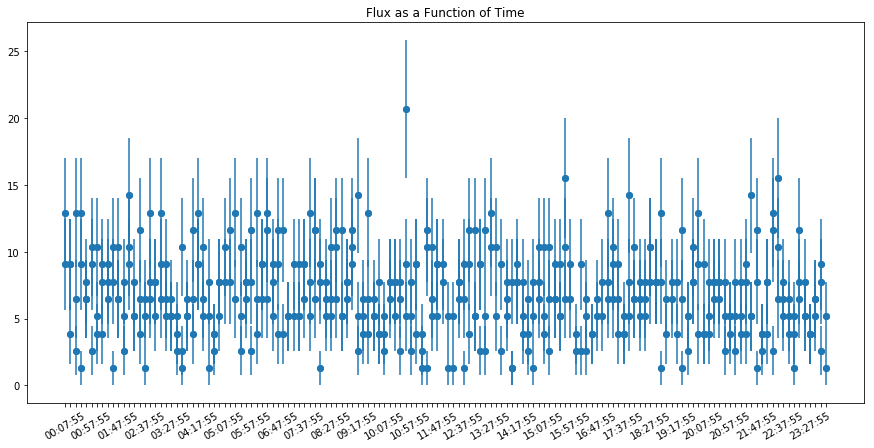

In [59]:
# Plotting Code
import matplotlib.pyplot as plt
with open('./OutputFiles/fluxOut') as flux:
    # 'lines' will be a list having each line of 'fluxOut' as an element
    lines = flux.readlines()
    # Remove the first two lines, which are comments
    lines = lines[2:]
    # Get the date
    date=str(lines[0].split()[0])
    
    # Split each line into x, y, and uncertainty arrays:
    x = [(line.split()[1]) for line in lines]
    y = [float(line.split()[2]) for line in lines]
    dy = [float(line.split()[3]) for line in lines]

# Make the output plot bigger:
#scale=15
#plt.rcParams["figure.figsize"]=[scale,scale]
plt.rcParams["figure.figsize"]=[15,7]

# Slant tick-labels on x-axis for readability
plt.xticks(rotation=30)

# Add a title
plt.title("Flux as a Function of Time")

plot = plt.scatter(x,y)

# Labels on the x-axis can become cluttered.  Thin them out if necessary
plt.setp(plot.axes.get_xticklabels(), visible=False)
plt.setp(plot.axes.get_xticklabels()[::5], visible=True)

# Add error bars
#   Amplify error bars just to see if they're really there:
#   dy = [20*i for i in dy]
plt.errorbar(x,y,yerr=dy,linestyle="None",fmt='o')
plt.show()

### Interpreting the Flux Plot

The flux plot has lots of scatter to it, but it's not hard to see a consistent average flux value of about $6 \,\rm{events/m^2/min}$.  What does this mean for the question we asked at the beginning of this exploration: how many cosmic ray muons passed through a sheet of notebook paper in one minute?

First we'll work out about what the area of our sheet of paper is in $m^2$.

In [61]:
# Consider an 8.5'' x 11'' sheet of paper.  Its area is
area_cm2 = (8.5*2.54)*(11*2.54)
area_m2 = (8.5*0.0254)*(11*0.0254)
print("A = " + str(area_cm2) + " cm^2 = " + str(area_m2) + " m^2")

A = 603.2246 cm^2 = 0.06032245999999999 m^2


Now we can find our answer for the total number of muons $N$ by multiplying the flux $\Phi$ by the area $A$ and the measurement time $t = 1 \,\rm{min}$.

$$
N = \Phi*A*t
$$

We can see that the units work out if we use $m^2$ for $A$:

$$
events = (events/m^2/min)*(m^2)*(min)
$$

And the answer is:

In [62]:
N = (6)*(0.0603)*(1)
print("N = " + str(N) + " muons")

N = 0.3618 muons


Interestingly, the number is less than one.  Does this mean that a little over a third of a muon hit the paper while we were timing?  Not quite.  The distinguishing feature of elementary particles like muons is that they can't be divided into smaller units, and we haven't discovered a contradiction to that rule.

Rather, this result indicates that it takes longer than a minute for a single muon to strike the paper, on average.  If we re-run the calculation with a time interval of $3\,\rm{min}$ instead of $1\,\rm{min}$, we find

In [63]:
N = (6)*(0.0603)*(3)
print("N = " + str(N) + " muons")

N = 1.0854 muons


That is, isn't until about 3 minutes have passed that we would expect our first (undivided) muon, assuming our measurement of the flux and our estimate of its average are correct. 

**_The Workflow Summarized_**

When we stop and consider the role of each App in the Flux Study workflow, as we did above, it's easy to lose track of the big picture.  For reference, this notebook's workflow is copied below, condensed into a single cell for readability (and commented out, of course, so that we don't run it twice when running the notebook!) 

In [ ]:
"""
WireDelay_futures = []
for i in range(len(thresholdAll)):
        WireDelay_futures.append(WireDelay(threshIn=thresholdAll[i], outputs=[wireDelayData[i]], 
                                           geoDir=geoDir, daqId=detectors[i], fw=firmwares[i]))
        
WireDelay_outputs = [i.outputs[0] for i in WireDelay_futures]

Combine_future = Combine(inputs=WireDelay_outputs, outputs=[combineOut])

SingleChannel_future = SingleChannel(inputs=Combine_future.outputs, outputs=[singleChannelOut], 
                                     channel=singlechannel_channel)

Sort_future = Sort(inputs=SingleChannel_future.outputs, outputs=[sortOut], 
                   key1=sort_sortKey1, key2=sort_sortKey2)

Flux_future = Flux(inputs=Sort_future.outputs, outputs=[fluxOut], binWidth=binWidth, geoDir=geoDir)

x = Flux_future.result()

print("Call to Flux completed with exit code:", x)
"""